In [1]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from multiprocessing import Pool
import piscola

%config InlineBackend.figure_format = 'retina'
print(f'piscola v{piscola.__version__}')
OUTDIR = 'output_piscola'

piscola v1.2.0


In [2]:
#os.environ['OPENBLAS_NUM_THREADS'] = '1'
#!export OPENBLAS_NUM_THREADS=2; export GOTO_NUM_THREADS=2; export OMP_NUM_THREADS=2; pip install piscola

In [2]:
from pathlib import Path

snpath = Path('../colour_law/data/2001ah.dat')
snpath.exists()

True

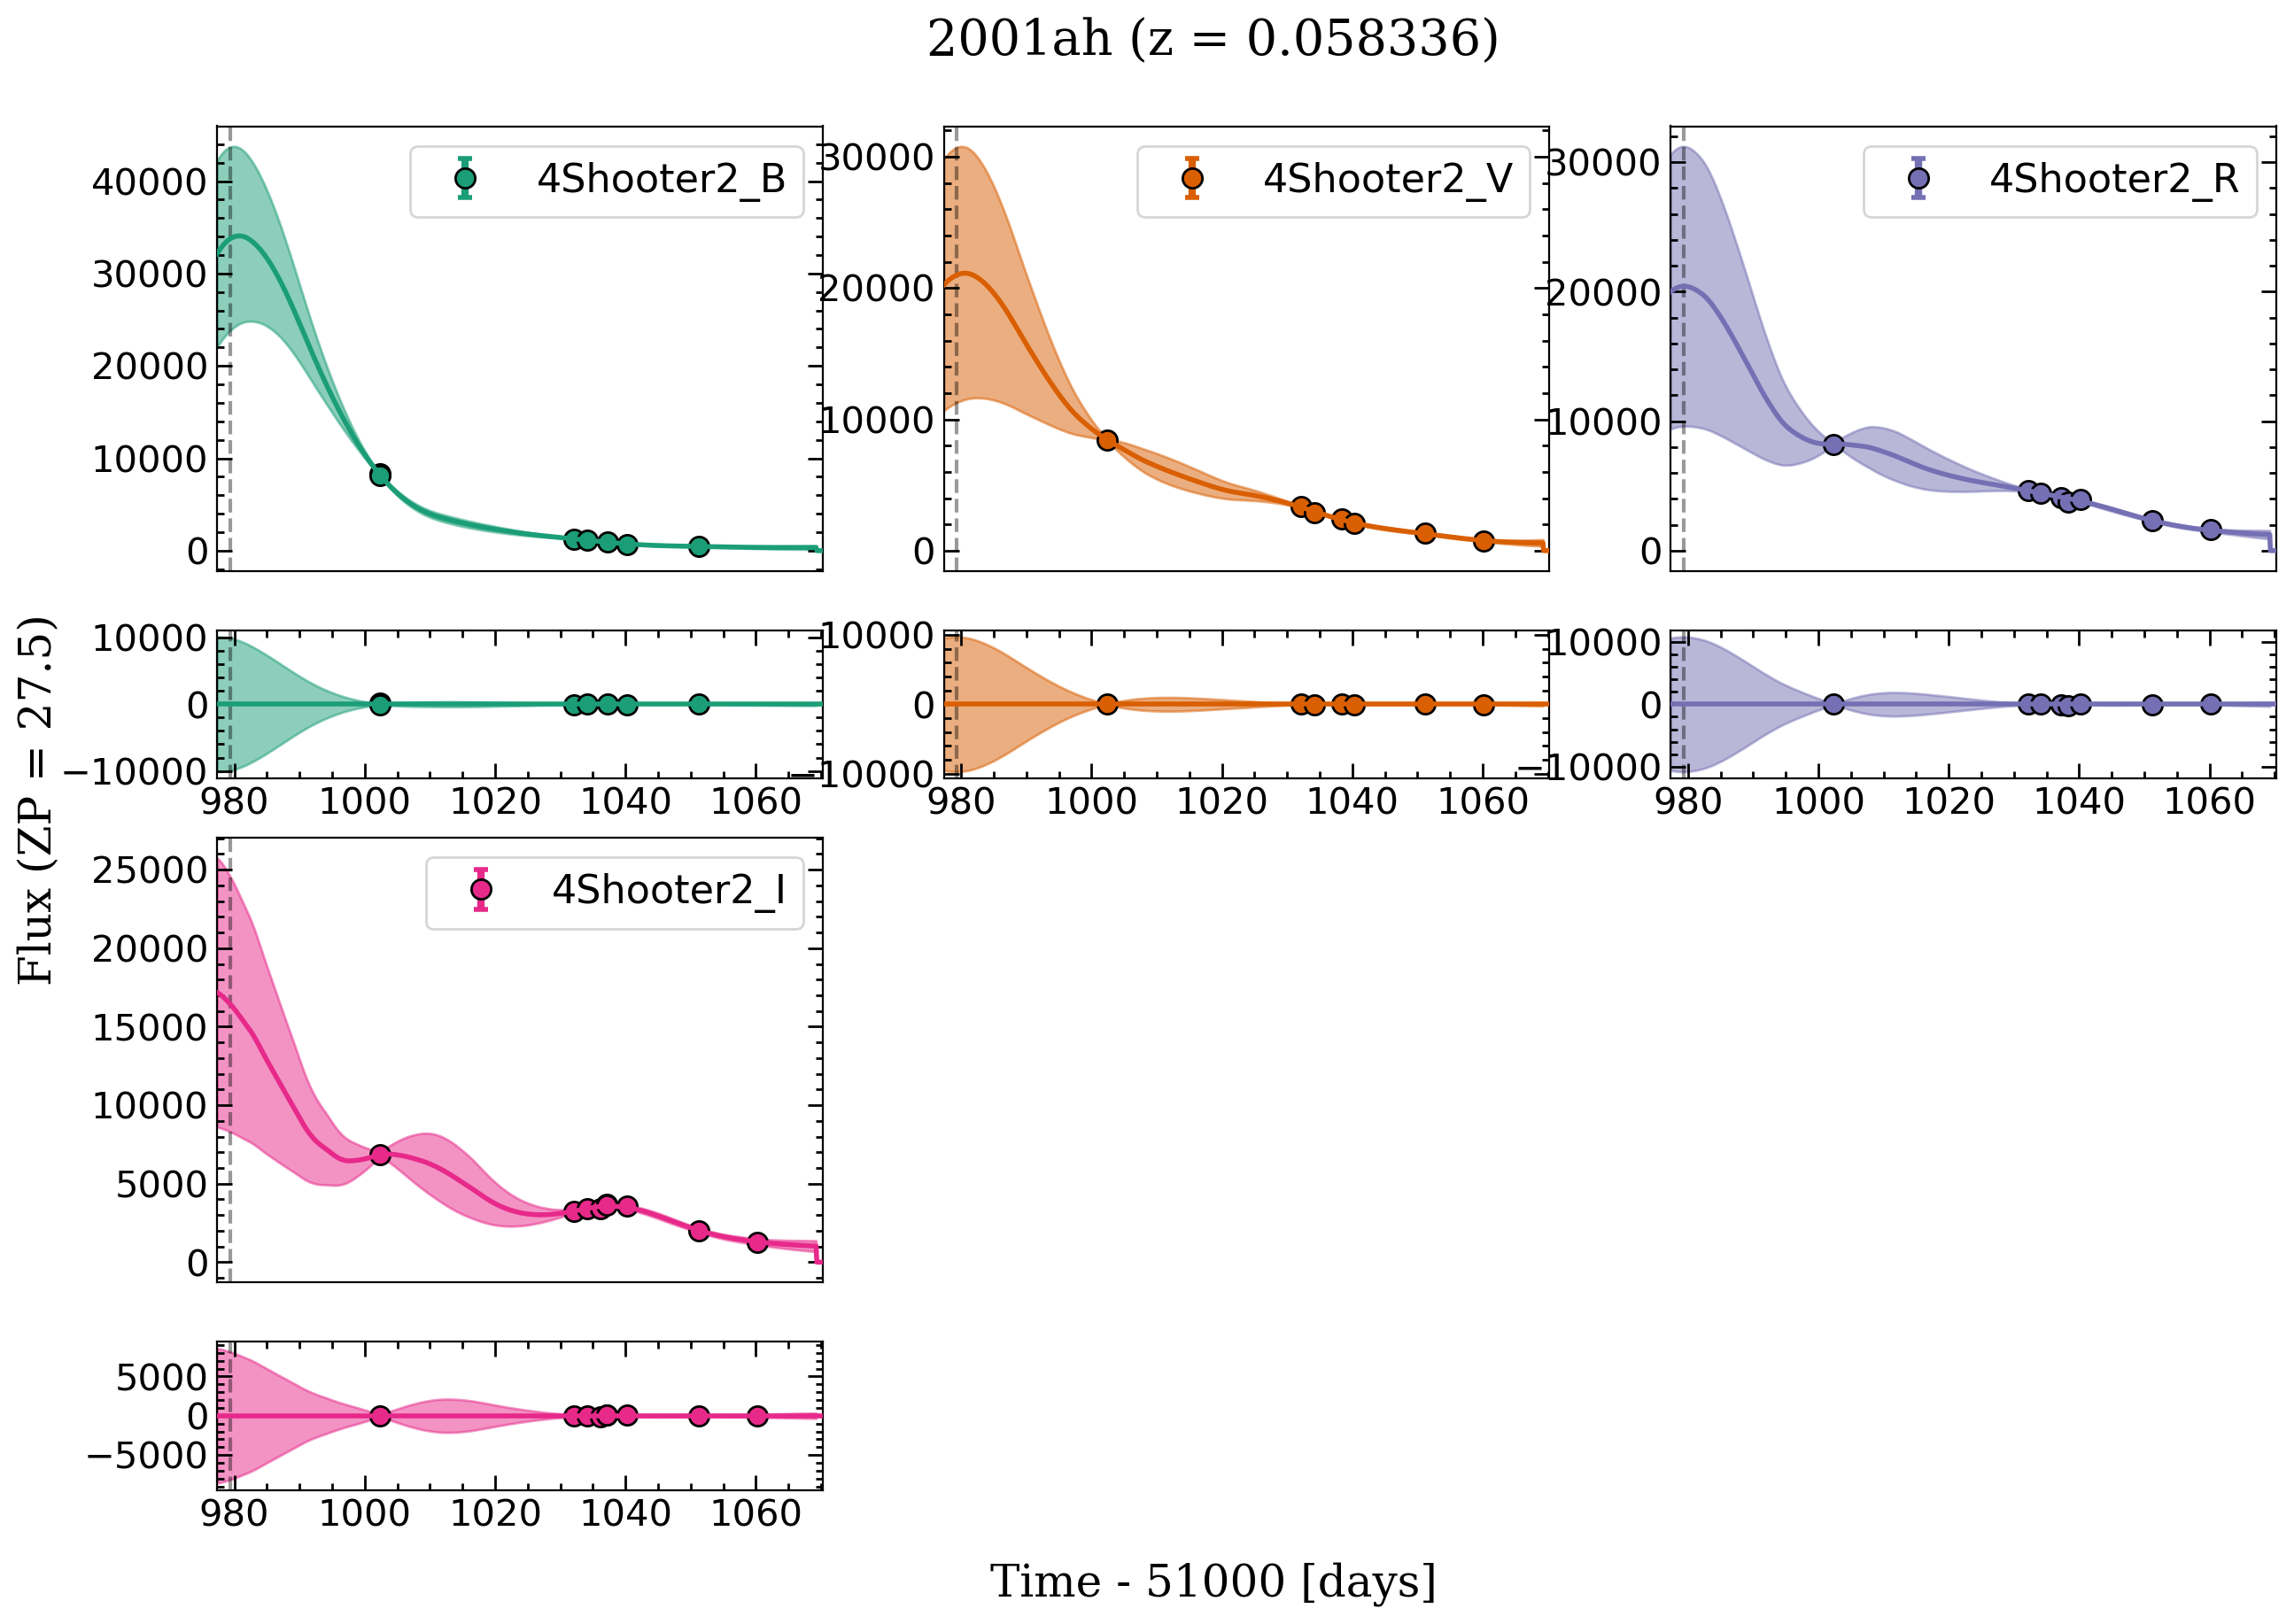

In [3]:
sn = piscola.call_sn(str(snpath))
for band in 'BVYJH':
    sn.add_filter(f'Swope_{band}', 'CSP_VEGA')
for band in 'ugri':
    sn.add_filter(f'Swope_{band}', 'CSP_BD17')
sn.fit()
sn.plot_fits(fig_name='SN2001ah2.jpg')

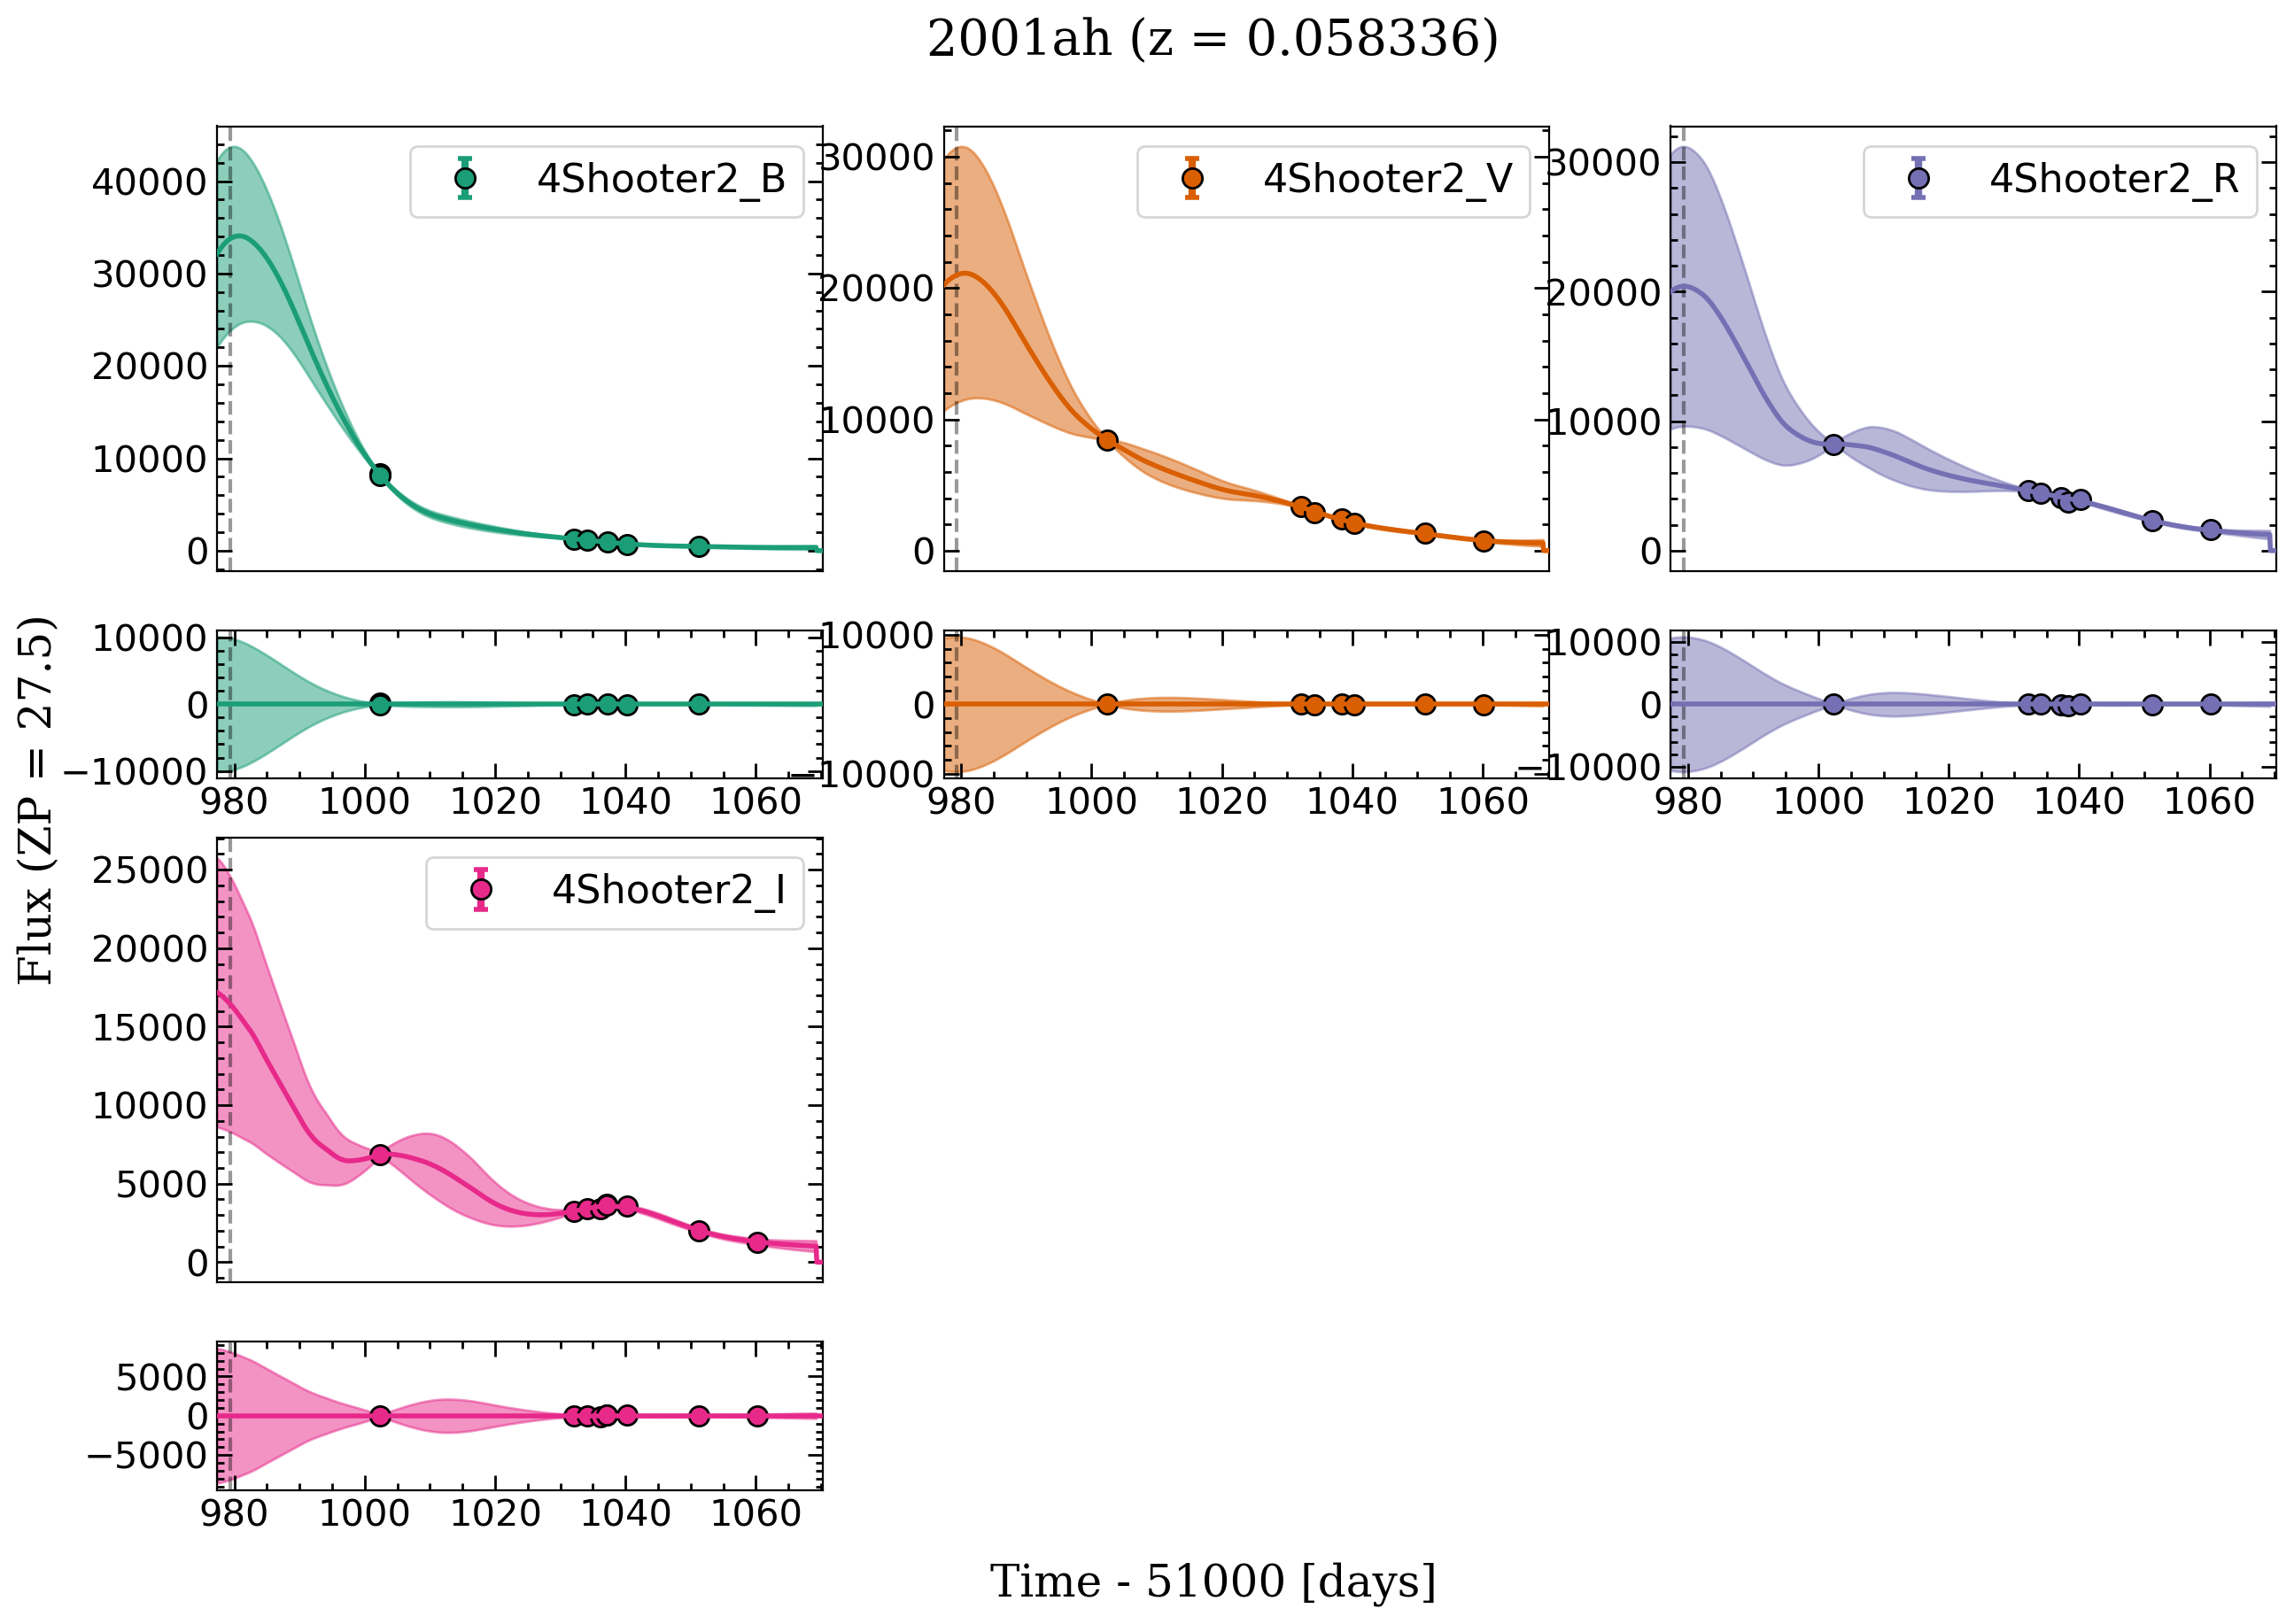

In [11]:
sn = piscola.call_sn('../colour_law/data/2001ah.dat')
sn.fit()
sn.plot_fits(fig_name='SN2001ah.jpg')

In [3]:
sn = piscola.call_sn('../colour_law/data/2020tug.dat')
sn.fit()
sn.plot_fits()

AssertionError: File ../colour_law/data/2020tug.dat not found.

In [4]:
sn = piscola.call_sn('../colour_law/data/2020fxa.dat')
sn.fit()
sn.plot_fits(fig_name='2020fxa.jpg')

AssertionError: File ../colour_law/data/2020fxa.dat not found.

In [5]:
sn = piscola.call_sn('../colour_law/data/asassn-13ch.dat')
sn.fit()
sn.plot_fits(fig_name='asassn-13ch.jpg')

AssertionError: File ../colour_law/data/asassn-13ch.dat not found.

In [10]:
def run_piscola(sn_file, overwrite=True):
    """Fit a SN with PISCOLA and save the results.
    
    Parameters
    ----------
    sn_file: str
        SN light-curve file.
    overwrite: bool, default 'True'
        If 'True', the SN is fitted even if a previous result exists.
        
    Returns
    -------
    sn_name: str DataFrame
        Name of the SN if the fit is successful, None otherwise
    """
    
    sn_name = os.path.basename(sn_file).split('.')[0]
    outfilefile = os.path.join(OUTDIR, f'{sn_name}.pisco')
    
    if overwrite is False and os.path.isfile(outfilefile) is True:
        return None
    
    try:
        print(f'starting with {sn_name}')
        sn = piscola.call_sn(sn_file)      
        for band in 'BVYJH':
            sn.add_filter(f'Swope_{band}', 'CSP_VEGA')
        for band in 'ugri':
            sn.add_filter(f'Swope_{band}', 'CSP_BD17')
        sn.fit()
        sn.save_sn(OUTDIR)
        print(f'{sn_name} successful!')    
    except Exception as exc: 
        print(f'{sn_name} failed: {exc}')

In [13]:
snfiles_path = Path('../colour_law/data')
[str(p) for p in snfiles_path]

['..\\colour_law\\data\\1248677.dat',
 '..\\colour_law\\data\\1250017.dat',
 '..\\colour_law\\data\\1253039.dat',
 '..\\colour_law\\data\\1253101.dat',
 '..\\colour_law\\data\\1253920.dat',
 '..\\colour_law\\data\\1255502.dat',
 '..\\colour_law\\data\\1257366.dat',
 '..\\colour_law\\data\\1257695.dat',
 '..\\colour_law\\data\\1258906.dat',
 '..\\colour_law\\data\\1258940.dat',
 '..\\colour_law\\data\\1259412.dat',
 '..\\colour_law\\data\\1261579.dat',
 '..\\colour_law\\data\\1262214.dat',
 '..\\colour_law\\data\\1262715.dat',
 '..\\colour_law\\data\\1263369.dat',
 '..\\colour_law\\data\\1263715.dat',
 '..\\colour_law\\data\\1275946.dat',
 '..\\colour_law\\data\\1279500.dat',
 '..\\colour_law\\data\\1280217.dat',
 '..\\colour_law\\data\\1281668.dat',
 '..\\colour_law\\data\\1281886.dat',
 '..\\colour_law\\data\\1282736.dat',
 '..\\colour_law\\data\\1283373.dat',
 '..\\colour_law\\data\\1283878.dat',
 '..\\colour_law\\data\\1283936.dat',
 '..\\colour_law\\data\\1285160.dat',
 '..\\colour

In [6]:
processes = 4
sn_files = [str(p) for p in Path('../colour_law/data').glob('*')]
#sn_files = [file for file in glob.glob('data/*') if os.path.basename(file).startswith('202')]
#sn_files = np.sort(sn_files)[::2]

Pool(processes).map(run_piscola, sn_files)

Keplercam_U --> Keplercam_Us
sn2016gxq only has ps1_w
could not convert string to float: 'None' --> missing redshift
asassn-15py has redshift
'<=' not supported between instances of 'str' and 'float' --> wrong file format

In [11]:
def save_pisco_results(sn_list, output_file):
    """Save different PISCOLA parameters into a pandas dataframe.
    
    Parameters
    ----------
    sn_list: list
        List with SN names
    obj_path: str
        Directory where to find the SN objects saved with PISCOLA
    output_file: str
        Name of the output csv file
        
    Returns
    -------
    params_df: pandas DataFrame
        Light-curve parameters
    """
    df_list = []
    for sn_name in sn_list: 
        input_file = os.path.join(OUTDIR, f'{sn_name}.pisco')
        sn = piscola.load_sn(input_file)
        
        sn_dict = {'name':[sn.name], 'z':[sn.z]}
        for param, value in sn.lc_parameters.items():
            sn_dict[param] = [value]

        sn_df = pd.DataFrame(sn_dict)
        df_list.append(sn_df)

    params_df = pd.concat(df_list)
    params_df.to_csv(output_file, index=False)

In [13]:
save_pisco_results([p.stem for p in Path('../colour_law/data').glob('*')], 'piscola_results.csv')